In [62]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras,squeeze
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.layers import TimeDistributed, Reshape, Input, Dense, Dropout, Flatten, Conv3D, MaxPooling3D,Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D, concatenate
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from os import system

from sklearn.metrics import roc_curve, auc, confusion_matrix,roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils as pic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 5000     # Training size
valid_size  = 1000     # Validation size
test_size   = 1000     # Test size
epochs      = 10       # Number of epochs
doGPU       = False    # Use GPU
tmin        = -0.1    # Minimum time cutoff
tmax        = 0.1     # Maximum time cutoff
tstep       = 0.0199   # Time steps

In [84]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [85]:
tc_train = pic.time_channels(X_train,normalize=False)
y_b_train = to_categorical(y_train)

In [86]:
tc_valid = pic.time_channels(X_valid,normalize=False)
y_b_valid = to_categorical(y_valid)

In [87]:
tc_test = pic.time_channels(X_test,normalize=False)
y_b_test = to_categorical(y_test)

[autoreload of utils.helpers failed: Traceback (most recent call last):
  File "/Users/bearcarlson/Library/Python/3.9/lib/python/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/bearcarlson/Library/Python/3.9/lib/python/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/bearcarlson/Google Drive/Classes

In [88]:
np.save('tc_train_5k.npy',tc_train)
np.save('tc_valid_1k.npy',tc_valid)
np.save('tc_test_1k.npy',tc_test)
system('mv *.npy data/')

0

In [89]:
tc_valid_e,tc_valid_p,average_valid_e,average_valid_p = pic.average_slice(tc_valid,y_valid) #xy is channel 0, xt is channel 1, yt is channel 2
tc_test_e,tc_test_p,average_test_e,average_test_p = pic.average_slice(tc_test,y_test) #xy is channel 0, xt is channel 1, yt is channel 2
tc_train_e,tc_train_p,average_train_e,average_train_p = pic.average_slice(tc_train,y_train) #xy is channel 0, xt is channel 1, yt is channel 2

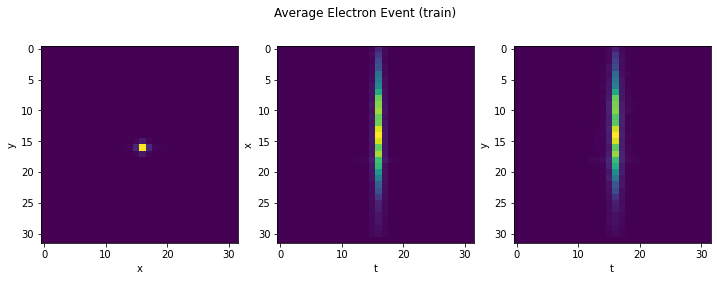

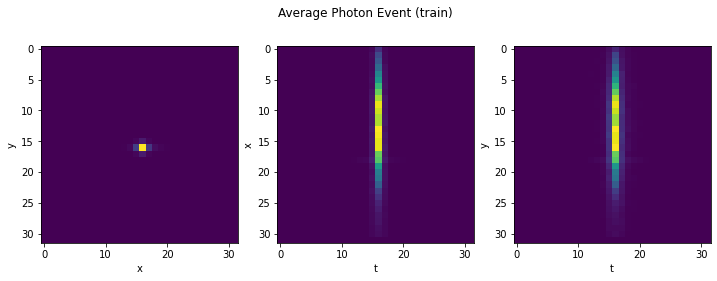

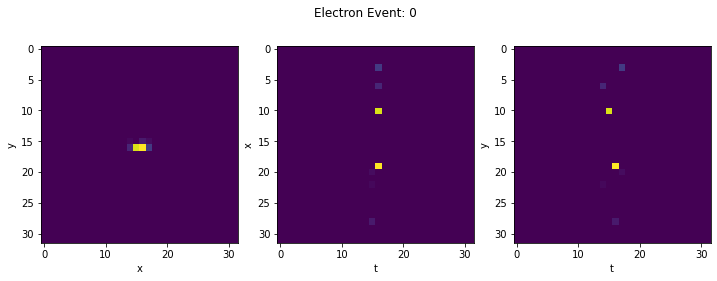

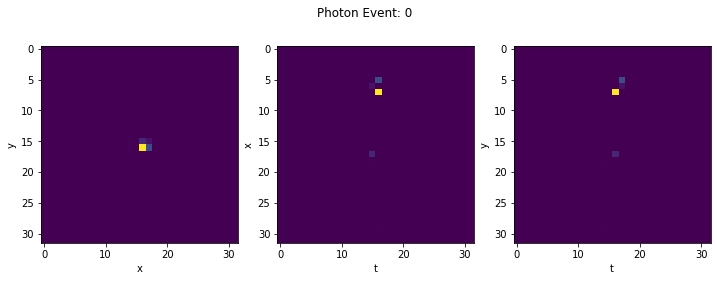

In [90]:
pic.plot_avgtcdecomposition(average_train_e,figtitle='Average Electron Event (train)')
pic.plot_avgtcdecomposition(average_train_p,figtitle='Average Photon Event (train)')
pic.plot_tcdecomposition(tc_train_e,figtitle='Electron')
pic.plot_tcdecomposition(tc_train_p,figtitle='Photon')

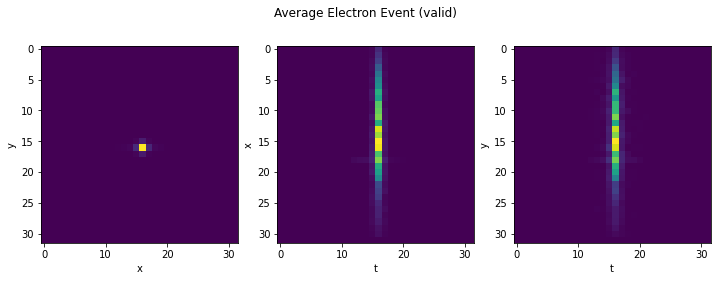

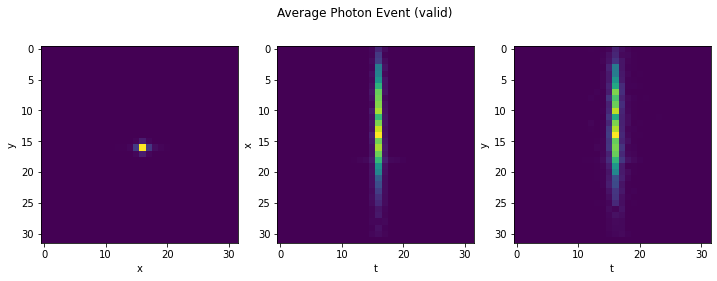

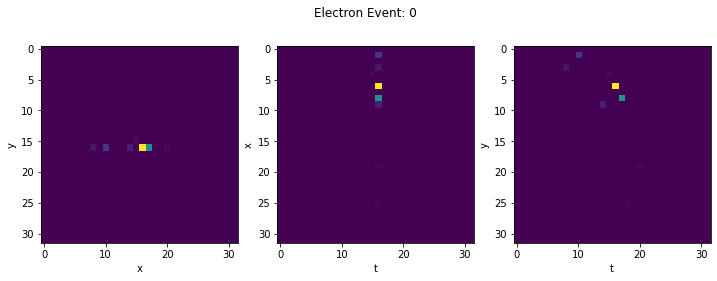

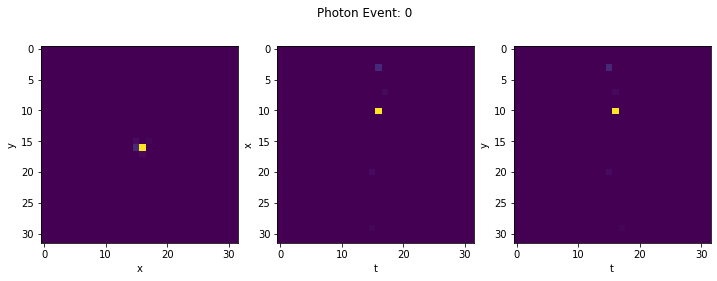

In [91]:
pic.plot_avgtcdecomposition(average_valid_e,figtitle='Average Electron Event (valid)')
pic.plot_avgtcdecomposition(average_valid_p,figtitle='Average Photon Event (valid)')
pic.plot_tcdecomposition(tc_valid_e,figtitle='Electron')
pic.plot_tcdecomposition(tc_valid_p,figtitle='Photon')

In [92]:
tc_train_t = np.stack((tc_train[:,:,:,1],tc_train[:,:,:,2]),axis=3)
tc_valid_t = np.stack((tc_valid[:,:,:,1],tc_valid[:,:,:,2]),axis=3)
tc_test_t = np.stack((tc_test[:,:,:,1],tc_test[:,:,:,2]),axis=3)


In [93]:
def google_net(input):
  conv2d_1 = Conv2D(strides=1,
                  filters=200, 
                  activation='relu', 
                  kernel_size=3, 
                  padding='same', 
                  kernel_initializer='TruncatedNormal')(input)
  max_pool_1 = MaxPooling2D(pool_size=2,strides=2,padding='same')(conv2d_1)
  conv2d_2 = Conv2D(strides=1,
                  filters=400, 
                  activation='relu', 
                  kernel_size=1, 
                  padding='same', 
                  kernel_initializer='TruncatedNormal')(max_pool_1)
  max_pool_2 = MaxPooling2D(pool_size=2,strides=1,padding='same')(conv2d_2)
  inception_1 = pic.inception2D(max_pool_2)
  inception_2 = pic.inception2D(inception_1)
  max_pool_3 = MaxPooling2D(pool_size=2,strides=2,padding='same')(inception_2)
  filter_sizes=[80,60,40]
  inception_3 = pic.inception2D(max_pool_3,filter_sizes=filter_sizes)
  inception_4 = pic.inception2D(inception_3,filter_sizes=filter_sizes)
  inception_5 = pic.inception2D(inception_4,filter_sizes=filter_sizes)
  inception_6 = pic.inception2D(inception_5,filter_sizes=filter_sizes)
  inception_7 = pic.inception2D(inception_6,filter_sizes=filter_sizes)
  max_pool_4 = MaxPooling2D(pool_size=2,strides=2,padding='same')(inception_7)
  filter_sizes=[80,60,40]
  inception_8 = pic.inception2D(max_pool_4,filter_sizes=filter_sizes)
  inception_9 = pic.inception2D(inception_8,filter_sizes=filter_sizes)
  avg_pool_5 = AveragePooling2D(pool_size=2,padding='same')(inception_9)
  flat_1 = Flatten()(avg_pool_5)
  dropout_1 = Dropout(0.4)(flat_1)
  dense_1 = Dense(1000,activation='relu')(dropout_1)
  output = Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal')(dense_1)
  return Model([input],output)

In [73]:
input_img = Input(shape=(32, 32, 3))
"""
#inception_1 = pic.inception2D(input_img,filter_sizes=[10,20,30])
conv_1 = Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',kernel_initializer='TruncatedNormal')(input_img)
normalize_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D()(normalize_1)
#inception_2 = pic.inception2D(maxpool_1,filter_sizes=[15,30,45])
conv_2 = Conv2D(filters=64,kernel_size=2,padding='same',activation='relu',kernel_initializer='TruncatedNormal')(maxpool_1)
normalize_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D()(normalize_2)
#inception_3 = pic.inception2D(maxpool_2,filter_sizes=[20,40,60])
conv_3 = Conv2D(filters=64,kernel_size=1,padding='same',activation='relu',kernel_initializer='TruncatedNormal')(maxpool_2)
normalize_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D()(normalize_3)
flatten_1 = Flatten()(maxpool_3)
dense_1 = Dense(600,activation='relu')(flatten_1)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(200,activation='relu')(dropout_1)
output = Dense(1,activation='sigmoid',kernel_initializer='TruncatedNormal')(dense_2)
model = Model([input_img],output)
"""
model = google_net(input_img)
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_298 (Conv2D)             (None, 32, 32, 200)  5600        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_83 (MaxPooling2D) (None, 16, 16, 200)  0           conv2d_298[0][0]                 
__________________________________________________________________________________________________
conv2d_299 (Conv2D)             (None, 16, 16, 400)  80400       max_pooling2d_83[0][0]           
___________________________________________________________________________________________

In [94]:
plot_model(model,show_shapes=True,to_file='googlenet_3chan_1.png')
system('mv *.png Models/')

0

In [95]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=lr_init),metrics=['accuracy'])

In [96]:
history = model.fit(
    tc_train, y_train,
    validation_data=(tc_valid,y_valid),
    epochs=10,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/10
100/100 [==============================] - 315s 3s/step - loss: 0.6928 - accuracy: 0.5075 - val_loss: 0.6923 - val_accuracy: 0.5260
Epoch 2/10
 11/100 [==>...........................] - ETA: 3:42 - loss: 0.6901 - accuracy: 0.5527

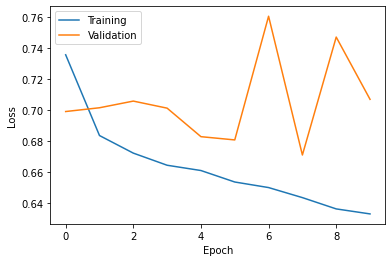

In [32]:
pic.plot_history(history,metric='loss')

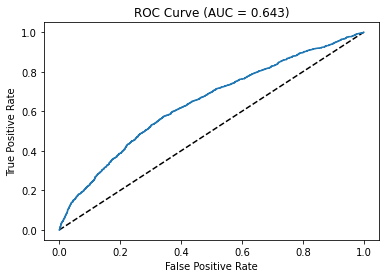

In [35]:
%matplotlib inline
pic.plot_roc(y_b_test[:,0], model.predict(tc_test_t)[:,0])
#0.684
#0.685
#0.626
#0.649
#0.643

In [17]:
history = model.fit(
    X_e_train, y_b_train,
    validation_data=(X_e_valid,y_b_valid),
    epochs=5,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/5
128/128 [==============================] - 1653s 13s/step - loss: 0.6215 - accuracy: 0.6632 - val_loss: 0.6852 - val_accuracy: 0.5774
Epoch 2/5
 40/128 [========>.....................] - ETA: 20:43 - loss: 0.6148 - accuracy: 0.6695

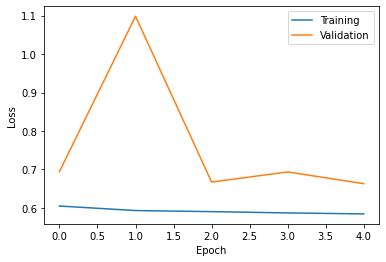

In [ ]:
pic.plot_history(history)

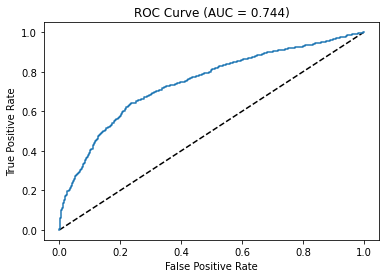

In [ ]:
%matplotlib inline
pic.plot_roc(y_b_test[:,0], model.predict(X_e_test)[:,0])